In [89]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np

"""
parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
"""
batch_size = 128
seed = 1
epochs = 300
cuda = True
log_interval = 10
sample_size = 10
h_d = 512
l_d = 32
u_d = 1



torch.manual_seed(seed)

### Preparing for the dataset

In [90]:
#hmnist dataset
import healing_mnist_indep

In [91]:
hmnist = healing_mnist_indep.HealingMNIST(seq_len=5, # 5 rotations of each digit
                                          square_count=0, # 3 out of 5 images have a square added to them
                                          square_size=5, # the square is 5x5
                                          noise_ratio=0.1, # on average, 20% of the image is eaten by noise,
                                          digits=range(10), # only include this digits
                                          test = False
                                         )

In [92]:
print(hmnist.train_images.shape,hmnist.train_targets.shape)
print(hmnist.train_rotations.shape)
print(hmnist.test_images.shape,hmnist.test_targets.shape)
print(hmnist.test_rotations.shape)

(60000, 5, 28, 28) (60000, 5, 28, 28)
(60000, 5)
(10000, 5, 28, 28) (10000, 5, 28, 28)
(10000, 5)


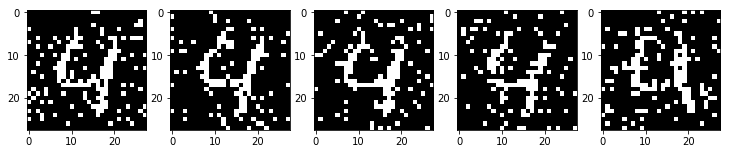

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline
case = 4
fig = plt.figure(figsize=(15,8))
for i, image in enumerate(hmnist.test_images[case]):
    fig.add_subplot(1, 6, i+1)
    plt.imshow(image,cmap='gray')
    

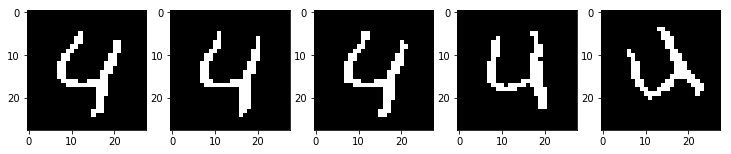

In [94]:
fig = plt.figure(figsize=(15,8))
for i, image in enumerate(hmnist.test_targets[case]):
    fig.add_subplot(1, 6, i+1)
    plt.imshow(image,cmap='gray')

In [95]:
print(hmnist.test_rotations[case])

[ -5.93870441   4.03446702  -2.34962547  21.43412511  25.80954221]


### Adjust the data shape
this part should be different for different model, the q-RNN model does not igorned the sequencial dependency within the dataset, so we don't need to flat the dataset. So that the dataset should be that given a sequence of noisy image $\{p_i\}$ and a sequences of action $\{u_i\}$, the target should be the image of next timestep given action $u_n$

In [96]:
train_X = hmnist.train_images
train_u = hmnist.train_rotations
train_Y = hmnist.train_targets
test_X = hmnist.test_images
test_u = hmnist.test_rotations
test_Y = hmnist.test_targets
print(train_X.shape,train_u.shape,train_Y.shape)
print(test_X.shape,test_u.shape,test_Y.shape)

(60000, 5, 28, 28) (60000, 5) (60000, 5, 28, 28)
(10000, 5, 28, 28) (10000, 5) (10000, 5, 28, 28)


In [97]:
#no adjustment needed

#train_Y = train_Y[:,4,:,:]
#test_Y = test_Y[:,4,:,:]

print(train_X.shape,train_u.shape,train_Y.shape)
print(test_X.shape,test_u.shape,test_Y.shape)

(60000, 5, 28, 28) (60000, 5) (60000, 5, 28, 28)
(10000, 5, 28, 28) (10000, 5) (10000, 5, 28, 28)


In [98]:
device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}

"""

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)



test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

"""



"\n\ntrain_loader = torch.utils.data.DataLoader(\n    datasets.MNIST('./data', train=True, download=True,\n                   transform=transforms.ToTensor()),\n    batch_size=batch_size, shuffle=True, **kwargs)\n\n\n\ntest_loader = torch.utils.data.DataLoader(\n    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),\n    batch_size=batch_size, shuffle=True, **kwargs)\n\n"

### Dataset object

In [99]:
class HMNISTDataSet():
    def __init__(self, train_img, train_act, train_tar, test_img, test_act, test_tar, test = False, transform=None):
        self.test = test
        self.transform = transform

        if (self.test == False):
          self.images = train_img
          self.targets = train_tar
          self.rotations = train_act

        else:      
          self.images = test_img
          self.targets = test_tar
          self.rotations = test_act

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        if self.transform is not None:
            img = torch.zeros((len(self.images[index]),1,28,28))
            for i in range(len(self.images[index])):
                img[i] = self.transform(self.images[index][i].reshape(28,28,1))
            tar = torch.zeros((len(self.targets[index]),1,28,28))
            for i in range(len(self.targets[index])):
                tar[i] = self.transform(self.targets[index][i].reshape(28,28,1))
                
            rot = torch.tensor(self.rotations[index])
        return img, rot, tar

In [100]:
train_set = HMNISTDataSet(train_X, train_u, train_Y, test_X, test_u, test_Y, test = False, transform = transforms.ToTensor())
test_set = HMNISTDataSet(train_X, train_u, train_Y, test_X, test_u, test_Y, test = True, transform = transforms.ToTensor())

In [101]:
a,b,c = train_set.__getitem__(3)
c.shape


torch.Size([5, 1, 28, 28])

### Create DataLoader

In [102]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, **kwargs)

### Model definition

In [103]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, h_d)
        self.fc2 = nn.Linear(h_d,128)
        self.fc21 = nn.Linear(128, l_d)
        self.fc22 = nn.Linear(128, l_d)
        
        #transition layer
        input_dim = l_d + u_d
        self.rnn_mu = nn.RNN(input_size=input_dim,hidden_size=l_d,batch_first=True)
        self.rnn_sigma = nn.RNN(input_size=input_dim,hidden_size=l_d,batch_first=True)
        
        
        self.fc3 = nn.Linear(l_d, 128)
        self.fc4 = nn.Linear(128,h_d)
        self.fc5 = nn.Linear(h_d, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize1(self, mu, logvar, n=1):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def transition(self, z, u):
        rnn_input = torch.cat((z,u),dim=2)
        mu2,_ = self.rnn_mu(rnn_input)
        logvar2,_ = self.rnn_sigma(rnn_input)
        return mu2,logvar2
    
    def reparameterize2(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        return torch.sigmoid(self.fc5(h4))

    def forward(self, x, u):
        mu1, logvar1 = self.encode(x.view(-1, 784))
        mu = torch.empty(sample_size, x.shape[0], x.shape[1], l_d , dtype=torch.float).to(device)
        logvar = torch.empty(sample_size, x.shape[0], x.shape[1], l_d , dtype=torch.float).to(device)
        for i in range(sample_size):
            z1 = self.reparameterize1(mu1, logvar1)
            z1 = z1.reshape(-1,5,32)
            u = u.float()
            mu2, logvar2 = self.transition(z1,u.reshape(-1,5,1))
            mu[i] = mu2
            logvar[i] = logvar2
        z2 = self.reparameterize2(mu[0], logvar[0])
        
        return self.decode(z2), mu, logvar

In [104]:
model = VAE().to(device)
#adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [105]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar[0,:,0,:] - mu[0,:,0,:].pow(2) - logvar[0,:,0,:].exp())
    EKLD = 0
    for i in range(1,5):        
        tmp = -0.5 * torch.sum(1 + logvar[:,:,i,:] - mu[:,:,i,:].pow(2) - logvar[:,:,i,:].exp())/sample_size
        EKLD += tmp
    return BCE + KLD + EKLD

### Define training and testing algorithm

In [106]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (img, action, target) in enumerate(train_loader):
        img = img.to(device)
        action = action.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(img,action)
        loss = loss_function(recon_batch, target, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        #if batch_idx % log_interval == 0:
         #   print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          #      epoch, batch_idx * len(img), len(train_loader.dataset),
           #     100. * batch_idx / len(train_loader),
            #    loss.item() / len(img)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return train_loss

In [107]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (img, action, target) in enumerate(test_loader):
            img = img.to(device)
            action = action.to(device)
            target = target.to(device)
            recon_batch, mu, logvar = model(img, action)
            test_loss += loss_function(recon_batch, target, mu, logvar).item()
            if(epoch > epochs - 10):
                if i == 0:
                    n = np.random.randint(0,batch_size)
                    comparison = torch.cat([target[n],
                                          recon_batch.view(batch_size, 5, 1, 28, 28)[n]],dim=0)
                    save_image(comparison.cpu(),
                             'results/reconstruction_' + str(epoch) + '.png', nrow=5)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

### Run training

In [108]:
import warnings;
warnings.filterwarnings('ignore')

train_losses = []
test_losses = []
for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    with torch.no_grad():
        if(epoch > epochs - 10):
            sample = torch.randn(64, l_d).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')


====> Epoch: 1 Average loss: 1103.6548
====> Test set loss: 1026.9961
====> Epoch: 2 Average loss: 1021.5959
====> Test set loss: 1011.6180
====> Epoch: 3 Average loss: 981.1678
====> Test set loss: 944.6881
====> Epoch: 4 Average loss: 926.1772
====> Test set loss: 908.1030
====> Epoch: 5 Average loss: 897.9745
====> Test set loss: 886.3565
====> Epoch: 6 Average loss: 879.4640
====> Test set loss: 871.2391
====> Epoch: 7 Average loss: 867.1103
====> Test set loss: 860.1757
====> Epoch: 8 Average loss: 857.4125
====> Test set loss: 853.7268
====> Epoch: 9 Average loss: 849.0622
====> Test set loss: 845.5340
====> Epoch: 10 Average loss: 842.0342
====> Test set loss: 841.2816
====> Epoch: 11 Average loss: 836.3677
====> Test set loss: 834.6133
====> Epoch: 12 Average loss: 831.3019
====> Test set loss: 831.2250
====> Epoch: 13 Average loss: 827.6014
====> Test set loss: 828.7788
====> Epoch: 14 Average loss: 824.0785
====> Test set loss: 823.9885
====> Epoch: 15 Average loss: 821.0787


====> Epoch: 119 Average loss: 768.6441
====> Test set loss: 790.9211
====> Epoch: 120 Average loss: 768.4867
====> Test set loss: 789.8792
====> Epoch: 121 Average loss: 768.1577
====> Test set loss: 789.4425
====> Epoch: 122 Average loss: 767.9120
====> Test set loss: 789.6094
====> Epoch: 123 Average loss: 768.0067
====> Test set loss: 790.6927
====> Epoch: 124 Average loss: 767.7738
====> Test set loss: 791.9990
====> Epoch: 125 Average loss: 768.0831
====> Test set loss: 791.7088
====> Epoch: 126 Average loss: 767.8597
====> Test set loss: 792.3231
====> Epoch: 127 Average loss: 767.7326
====> Test set loss: 789.5397
====> Epoch: 128 Average loss: 767.5408
====> Test set loss: 791.9521
====> Epoch: 129 Average loss: 767.2184
====> Test set loss: 790.7419
====> Epoch: 130 Average loss: 767.2962
====> Test set loss: 790.5433
====> Epoch: 131 Average loss: 767.0374
====> Test set loss: 792.3177
====> Epoch: 132 Average loss: 766.7622
====> Test set loss: 788.7123
====> Epoch: 133 Ave

====> Epoch: 236 Average loss: 758.3846
====> Test set loss: 790.9010
====> Epoch: 237 Average loss: 759.2598
====> Test set loss: 792.5877
====> Epoch: 238 Average loss: 758.3031
====> Test set loss: 790.3504
====> Epoch: 239 Average loss: 758.6287
====> Test set loss: 791.3690
====> Epoch: 240 Average loss: 758.2634
====> Test set loss: 791.0162
====> Epoch: 241 Average loss: 758.7448
====> Test set loss: 790.3076
====> Epoch: 242 Average loss: 758.3062
====> Test set loss: 790.5515
====> Epoch: 243 Average loss: 757.6874
====> Test set loss: 791.3333
====> Epoch: 244 Average loss: 757.7100
====> Test set loss: 790.5978
====> Epoch: 245 Average loss: 758.5691
====> Test set loss: 791.0303
====> Epoch: 246 Average loss: 757.6480
====> Test set loss: 790.3659
====> Epoch: 247 Average loss: 758.4398
====> Test set loss: 789.4741
====> Epoch: 248 Average loss: 758.0374
====> Test set loss: 790.6081
====> Epoch: 249 Average loss: 757.8214
====> Test set loss: 788.8736
====> Epoch: 250 Ave

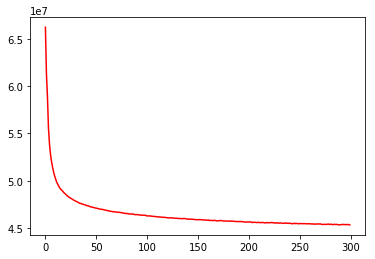

In [109]:
plt.plot(np.array(train_losses),'r')
plt.show()

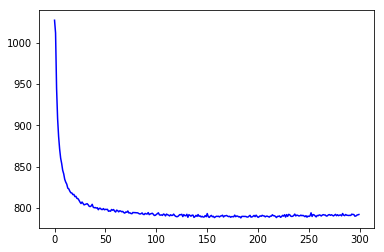

In [110]:
plt.plot(np.array(test_losses),'b')
plt.show()